In [1]:
library('vars')

Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest



In [2]:
library('tsDyn')

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [3]:
library('Hmisc')

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units




In [4]:
library('feasts')

Loading required package: fabletools


Attaching package: 'fabletools'


The following object is masked from 'package:tsDyn':

    MAPE




In [5]:
library('tsibble')


Attaching package: 'tsibble'


The following object is masked from 'package:zoo':

    index




In [6]:
library('lubridate')


Attaching package: 'lubridate'


The following object is masked from 'package:tsibble':

    interval


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [7]:
library("ggpubr")

In [8]:
library('dyn')

In [9]:
library('DataCombine')


Attaching package: 'DataCombine'


The following object is masked from 'package:tsibble':

    slide




In [10]:
library('tidyverse')

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x lubridate::as.difftime() masks base::as.difftime()
x stringr::boundary()      masks strucchange::boundary()
x lubridate::date()        masks base::date()
x dplyr::filter()          masks stats::filter()
x lubridate::intersect()   masks base::intersect()
x lubridate::interval()    masks tsibble::interval()
x dplyr::lag()             masks stats::lag()
x dplyr::select()          masks MASS::select()
x lubridate::setdiff()     masks base::setdiff()
x dplyr::src()             masks Hmisc::src()
x dplyr::summarize()       masks Hmisc::summarize()
x lubridate::union()       masks base::union()



In [11]:
install.packages('DataCombine')

Warning message:
"package 'DataCombine' is in use and will not be installed"


In [12]:
# uploading data that includes weekly log-returns of bitcoin and the popularity of search term 'bitcoin' measured by Google Trends 
# the log-returns of popularity of search term 'bitcoin' means the log(r(t)/r(t-1)), where r is the popularity of search term 'bitcoin'
data_ira <- read.csv('C:/Users/pawel/PycharmProjects/quandl/ira.csv')

In [13]:
# deleting redundant column
data_ira$X<-NULL

In [14]:
data_ira$date <- as.Date(data_ira$date)

In [15]:
str(data_ira)

'data.frame':	260 obs. of  3 variables:
 $ date     : Date, format: "2016-01-17" "2016-01-24" ...
 $ change   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ change_bt: num  -0.05571 0.00723 0.00259 -0.03542 0.01854 ...


In [16]:
data_ira <- data_ira %>% 
  rename(
    google_trends_change = change,
    bitcoin_change = change_bt
    )

In [17]:
#Phillips-Perron stationarity test
pptab<-NULL
for(i in 2:ncol(data_ira)){
pp<-PP.test(data_ira[,i])
pptab<-rbind(pptab,pp$p.value)
}
pptab

0.01
0.01


In [18]:
# both time series are stationary at 0.01

`geom_smooth()` using formula 'y ~ x'



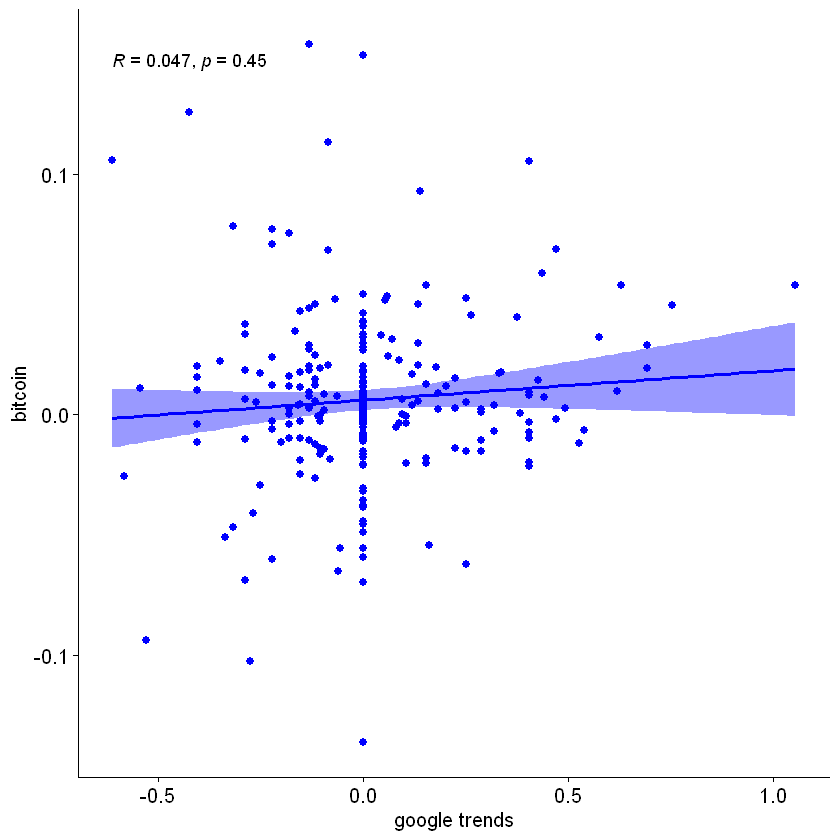

In [19]:
# correlation between variables (pearson)
ggscatter(data_ira[2:3], x = "google_trends_change", y = "bitcoin_change",
          color = "blue", cor.coef = TRUE, conf.int = TRUE,
          cor.method = "spearman", add = 'reg.line',
          xlab = "google trends", ylab = "bitcoin")

In [20]:
res <- cor.test(data_ira$google_trends_change, data_ira$bitcoin_change, 
                    method = "pearson")

In [21]:
res


	Pearson's product-moment correlation

data:  data_ira$google_trends_change and data_ira$bitcoin_change
t = 1.3211, df = 258, p-value = 0.1876
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.04007991  0.20161652
sample estimates:
       cor 
0.08197345 


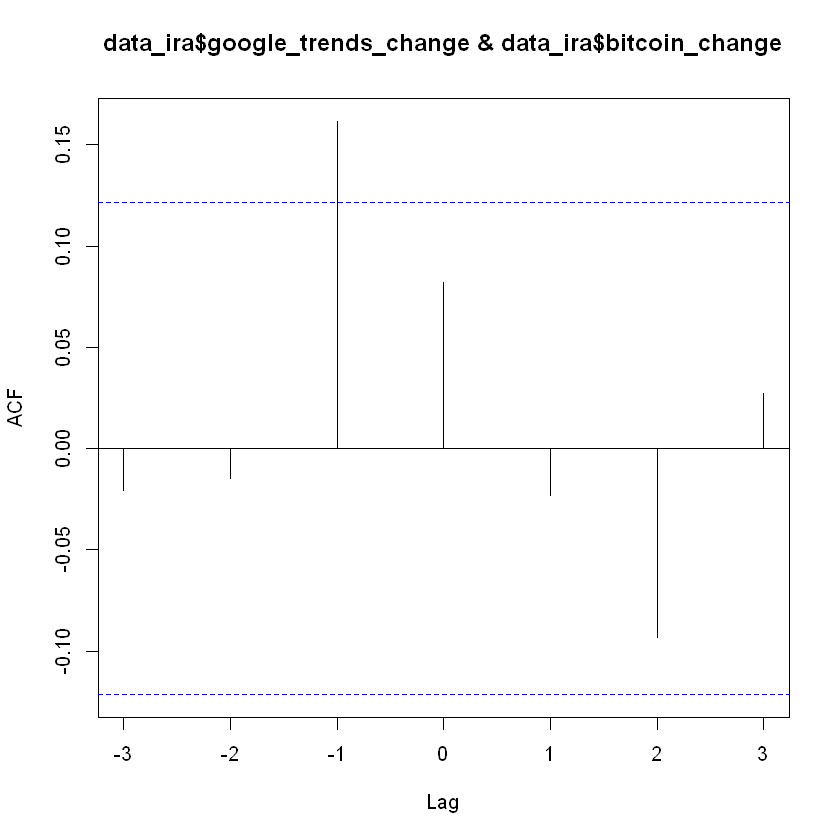

In [23]:
# the correlation between google's trend log(t-1/t-2) and bitcoin log(t/t-1) is statistically significant
ccf(data_ira$google_trends_change, data_ira$bitcoin_change, 3) 

In [25]:
# crosscorrelation function of x and y is significant at lag -1 of variable google_trends_change
# it means that google_trends_change from previous week is significantly correlated with bitcoin change from current week

In [40]:
lag_var <- Lag(data_ira$google_trends_change,+1)

In [41]:
data_ira <- cbind(data_ira, lag_var)

In [43]:
data_ira <- data_ira[c(-4)]

In [44]:
lm_model <- lm(bitcoin_change ~ lag_var, data = data_ira)

In [45]:
summary(lm_model)


Call:
lm(formula = bitcoin_change ~ lag_var, data = data_ira)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.136891 -0.014323 -0.001774  0.011584  0.140525 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) 0.006154   0.002104   2.925  0.00375 **
lag_var     0.024475   0.009196   2.661  0.00827 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03382 on 257 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.02682,	Adjusted R-squared:  0.02303 
F-statistic: 7.083 on 1 and 257 DF,  p-value: 0.008274


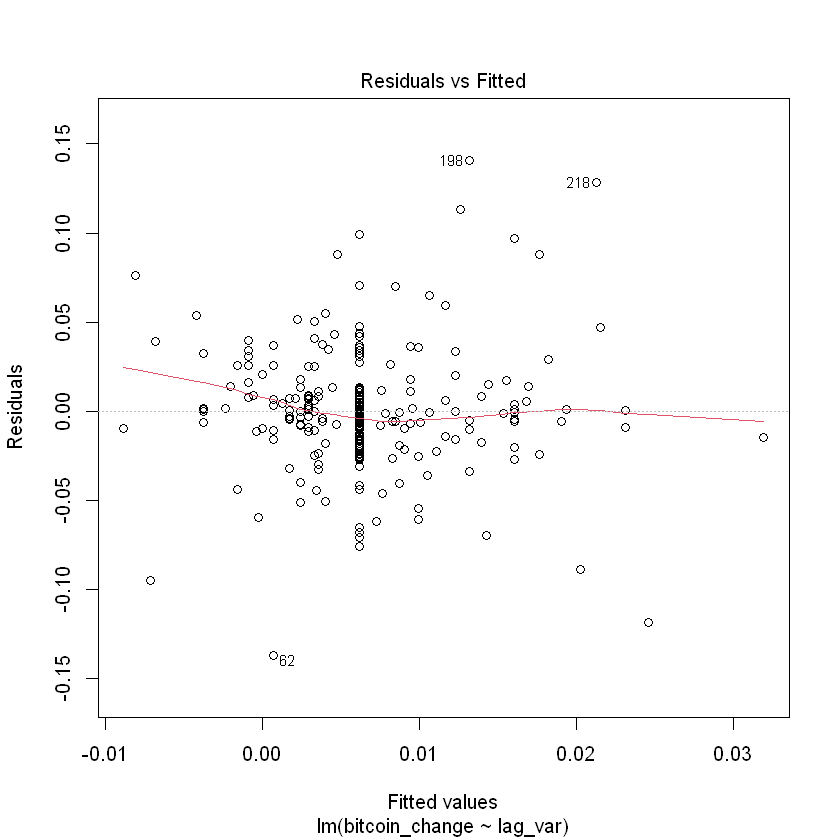

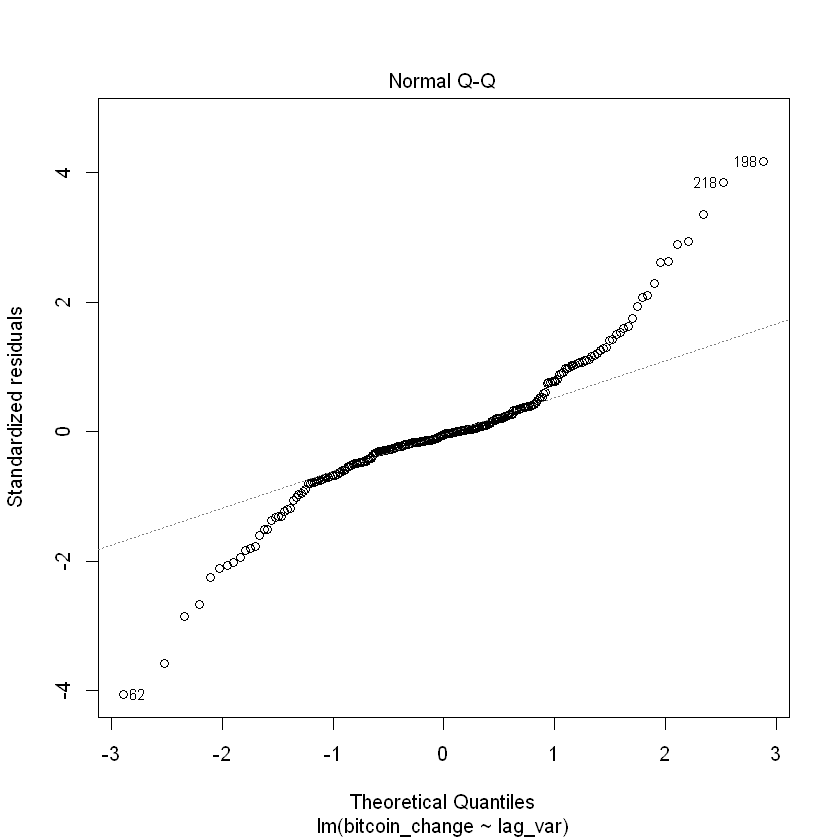

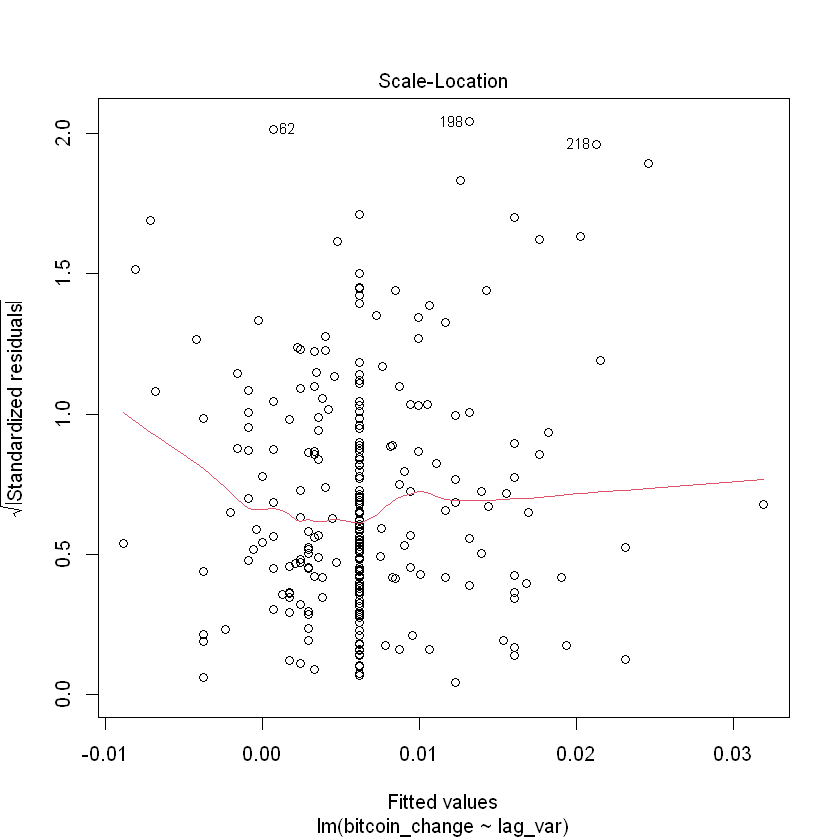

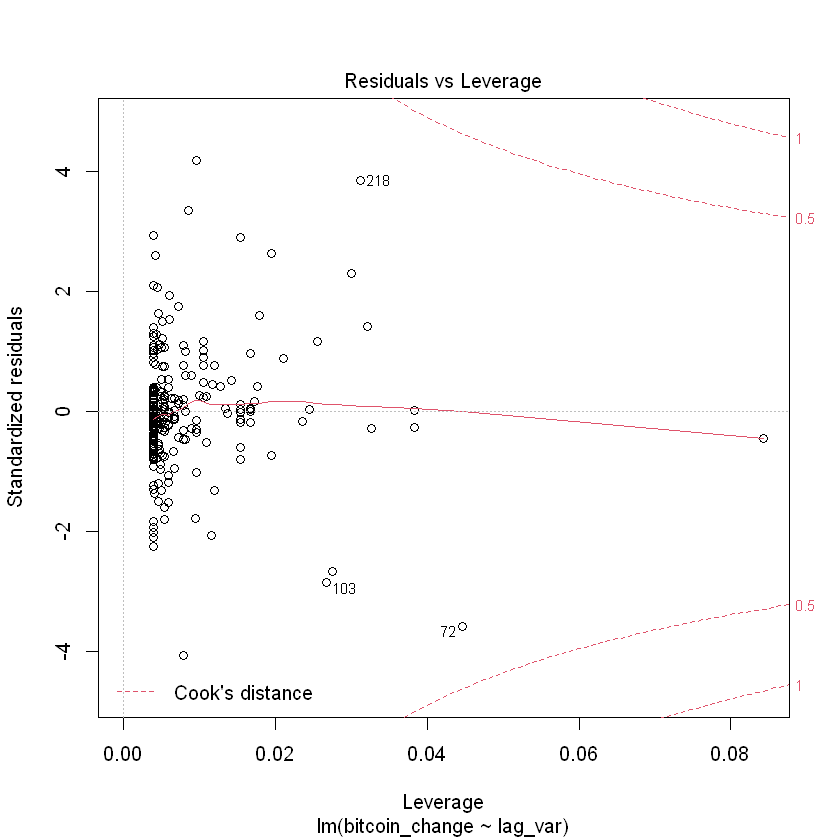

In [46]:
plot(lm_model)

In [47]:
# optimal lag selection
lag_bitcoin <- VARselect(data_ira[, c('google_trends_change','bitcoin_change')])

In [48]:
lag_bitcoin

,1,2,3,4,5,6,7,8,9,10
AIC(n),-9.6452138813,-9.627848e+00,-9.603176e+00,-9.591649e+00,-9.582817e+00,-9.568111e+00,-9.554330e+00,-9.530508e+00,-9.503613e+00,-9.498421e+00
HQ(n),-9.6111990420,-9.571157e+00,-9.523808e+00,-9.489605e+00,-9.458096e+00,-9.420714e+00,-9.384256e+00,-9.337757e+00,-9.288185e+00,-9.260317e+00
SC(n),-9.5606988192,-9.486990e+00,-9.405974e+00,-9.338104e+00,-9.272929e+00,-9.201879e+00,-9.131755e+00,-9.051589e+00,-8.968350e+00,-8.906816e+00
FPE(n),0.0000647348,6.586933e-05,6.751593e-05,6.830093e-05,6.891038e-05,6.993645e-05,7.091408e-05,7.263327e-05,7.462573e-05,7.502964e-05


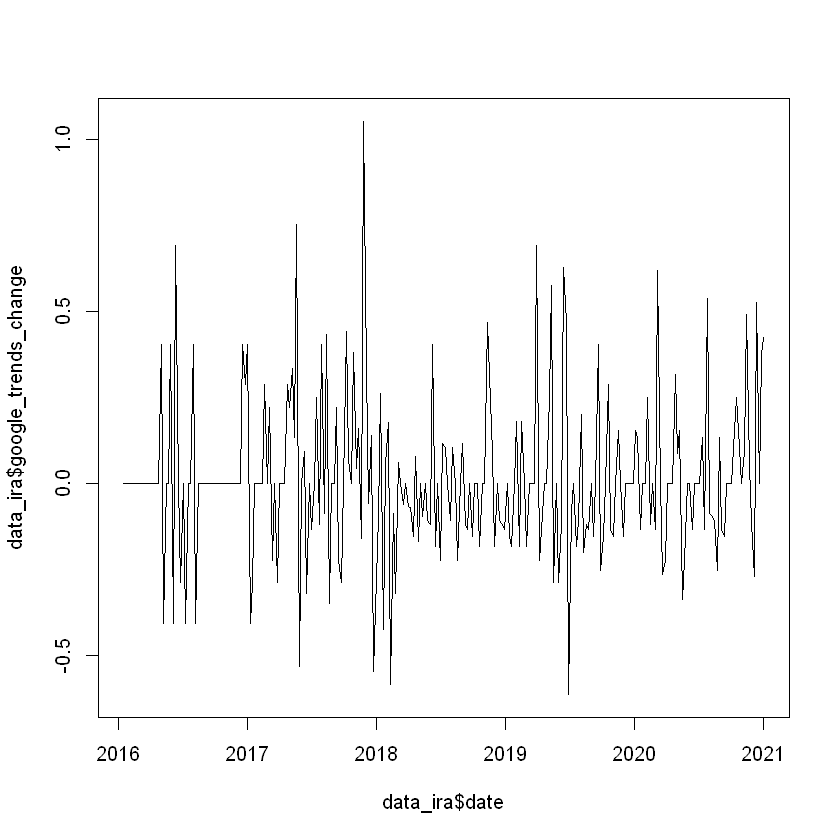

In [49]:
plot(data_ira$date, data_ira$google_trends_change, type = 'l')

In [50]:
data_ira <- DropNA(data_ira, Var='lag_var')

1 rows dropped from the data frame because of missing values.



In [51]:
# Vector Auto-Regression model
VAR_mod <- VAR(data_ira[, c('bitcoin_change', 'google_trends_change')],type = 'const', lag.max = 1, ic = 'SC')

In [52]:
VAR_mod


VAR Estimation Results:

Estimated coefficients for equation bitcoin_change: 
Call:
bitcoin_change = bitcoin_change.l1 + google_trends_change.l1 + const 

      bitcoin_change.l1 google_trends_change.l1                   const 
           -0.044171621             0.025010809             0.006426156 


Estimated coefficients for equation google_trends_change: 
Call:
google_trends_change = bitcoin_change.l1 + google_trends_change.l1 + const 

      bitcoin_change.l1 google_trends_change.l1                   const 
            -0.11456776             -0.08362170              0.01402826 



In [53]:
# granger causality
gc<-causality(VAR_mod,cause = colnames(VAR_mod$datamat[2]))

In [54]:
gc

$Granger

	Granger causality H0: google_trends_change do not Granger-cause
	bitcoin_change

data:  VAR object VAR_mod
F-Test = 7.305, df1 = 1, df2 = 510, p-value = 0.007106


$Instant

	H0: No instantaneous causality between: google_trends_change and
	bitcoin_change

data:  VAR object VAR_mod
Chi-squared = 2.4035, df = 1, p-value = 0.1211



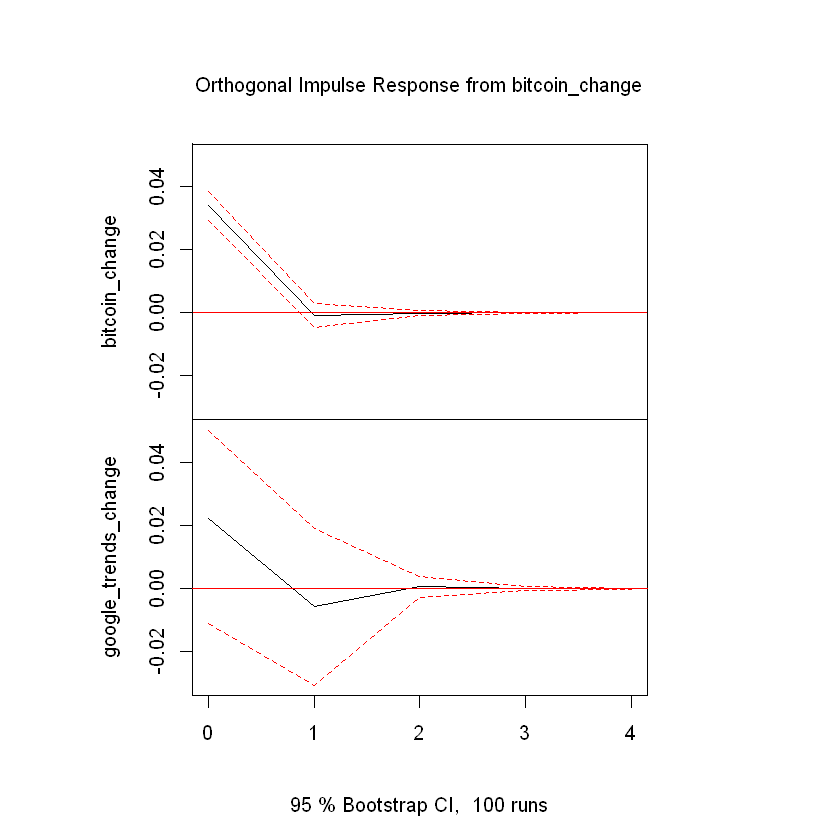

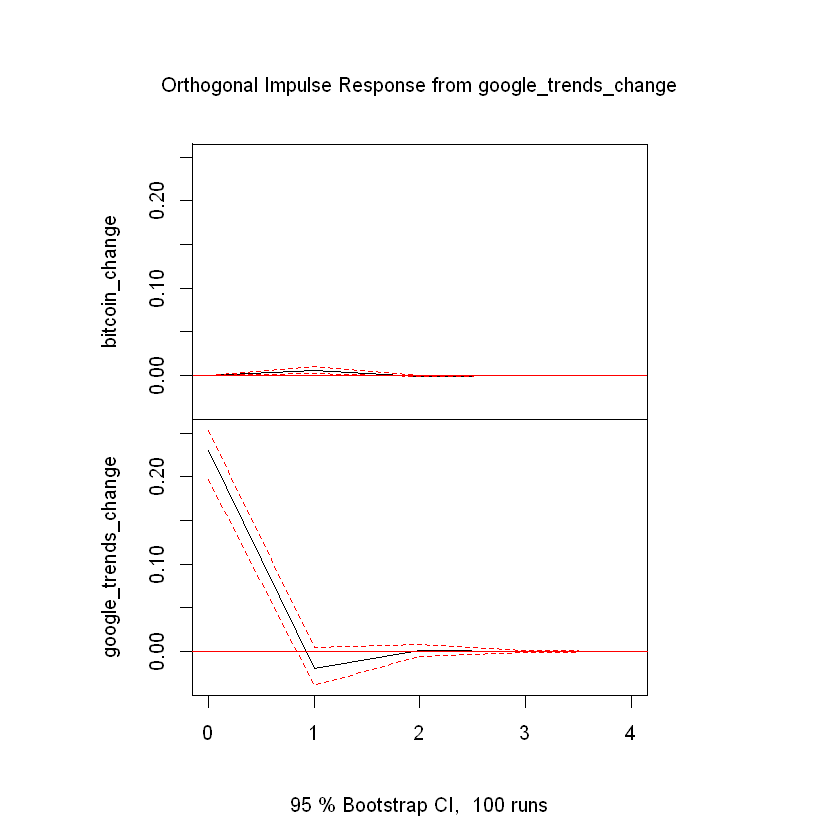

In [55]:
# impulse response function
plot(irf(VAR_mod, n.ahead=4))

In [56]:
# Variance decomposition of forecast errors at 1,2,3,4 weeks horizon
fevd1<-fevd(VAR_mod,n.ahead = 4)

In [57]:
fevd1

$bitcoin_change
     bitcoin_change google_trends_change
[1,]      1.0000000           0.00000000
[2,]      0.9721090           0.02789100
[3,]      0.9716667           0.02833333
[4,]      0.9716641           0.02833591

$google_trends_change
     bitcoin_change google_trends_change
[1,]    0.009403559            0.9905964
[2,]    0.009950423            0.9900496
[3,]    0.009956652            0.9900433
[4,]    0.009956677            0.9900433


In [58]:
fevd2<-fevd1$bitcoin_change

In [59]:
fevdtab<-round(100*fevd2[c(1,2,3,4),],2)

In [60]:
rownames(fevdtab)<-c(1,2,3,4)

In [61]:
print(fevdtab)

  bitcoin_change google_trends_change
1         100.00                 0.00
2          97.21                 2.79
3          97.17                 2.83
4          97.17                 2.83
